<a href="https://colab.research.google.com/github/liuyx211/CS230-Project/blob/main/convert_xml_to_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

%matplotlib inline

random.seed(108)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_path = "/content/drive/MyDrive/newCS230/test/images"
xml_path ="/content/drive/MyDrive/newCS230/test/xml_labels"
yolo_path ="/content/drive/MyDrive/newCS230/test/yolo_labels"

In [ ]:
!cat $xml_path/1.xml

<annotation>
	<folder>newdataset</folder>
	<filename>1.jpeg</filename>
	<path>D:\Documents\stanford\sem13\CS230\projects\CS230 project\newdataset\1.jpeg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1572</width>
		<height>1164</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>card</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>20</xmin>
			<ymin>32</ymin>
			<xmax>1507</xmax>
			<ymax>1132</ymax>
		</bndbox>
	</object>
	<object>
		<name>header</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>67</xmin>
			<ymin>60</ymin>
			<xmax>1091</xmax>
			<ymax>148</ymax>
		</bndbox>
	</object>
	<object>
		<name>history</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>60</xmin>
			<ymin>542</ymin>
			<xmax>1462</xmax>
			<ymax>1085</ymax>
		</bndbox>
	</object>


In [ ]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

In [ ]:
print(extract_info_from_xml(xml_path + '/1.xml'))

{'bboxes': [{'class': 'card', 'xmin': 20, 'ymin': 32, 'xmax': 1507, 'ymax': 1132}, {'class': 'header', 'xmin': 67, 'ymin': 60, 'xmax': 1091, 'ymax': 148}, {'class': 'history', 'xmin': 60, 'ymin': 542, 'xmax': 1462, 'ymax': 1085}], 'filename': '1.jpeg', 'image_size': (1572, 1164, 3)}


In [ ]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {"card": 0,
                           "header": 1,
                           "logo": 2,
                           "history": 3}

# Convert the info dict to the required yolo format and write it to disk
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join(yolo_path, info_dict["filename"].replace("jpeg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

In [ ]:
# Get the annotations
annotations = [os.path.join(xml_path, x) for x in os.listdir(xml_path) if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

annotations = [os.path.join(yolo_path, x) for x in os.listdir(yolo_path) if x[-3:] == "txt"]

100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


[[0.0, 0.486, 0.5, 0.946, 0.945], [1.0, 0.368, 0.089, 0.651, 0.076], [3.0, 0.484, 0.699, 0.892, 0.466]]


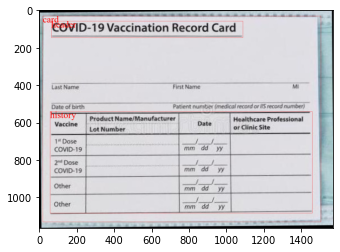

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]

    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)), outline = 'red')
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))], fill = 'red', font=ImageFont.truetype('/content/drive/MyDrive/newCS230/font/TIMES.TTF',size = 50))
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = annotations[0]
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace(yolo_path, image_path).replace("txt", "jpeg")
assert os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
print(annotation_list)
plot_bounding_box(image, annotation_list)